# SF taxi GPS OD analysis

Trip-level OD from GPS endpoints. This notebook builds tract-level OD networks and computes a compact set of structural/spatial metrics that can be reused for larger GPS datasets.


In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path


## 1) Load trips and tract polygons

Set paths once.

In [2]:
# paths
TRIPS_CSV = Path("/Users/nautim/Downloads/sf_dataset.csv")
TRACTS_SHP = Path("/Users/nautim/Downloads/region_2020_censustract_-2258913428005339031/region_2020_censustract.shp")

# load trips
df = pd.read_csv(TRIPS_CSV)
df["timestamp"] = pd.to_datetime(df["timestamp"]).dt.tz_localize(
    "America/Los_Angeles",
    ambiguous="infer",
    nonexistent="shift_forward",
)
df = df.sort_values(["trajectory", "timestamp"]).reset_index(drop=True)

# parse geometry
df["start_geom"] = df["start_point"].apply(wkt.loads)
df["end_geom"] = df["end_point"].apply(wkt.loads)

df["start_lon"] = df["start_geom"].apply(lambda p: p.x)
df["start_lat"] = df["start_geom"].apply(lambda p: p.y)
df["end_lon"] = df["end_geom"].apply(lambda p: p.x)
df["end_lat"] = df["end_geom"].apply(lambda p: p.y)

# tracts
tracts = gpd.read_file(TRACTS_SHP).to_crs("EPSG:4326").copy()

# set this to the tract GEOID column in your shapefile
TRACT_ID_COL = "geoid"
tracts[TRACT_ID_COL] = tracts[TRACT_ID_COL].astype(str)


/opt/anaconda3/envs/phd_work/lib/python3.12/site-packages/pyogrio/raw.py:200: RuntimeWarning: /Users/nautim/Downloads/region_2020_censustract_-2258913428005339031/region_2020_censustract.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


## 2) Trip distance and time features

In [3]:
def haversine_m(lon1, lat1, lon2, lat2):
    r = 6371000.0
    lon1 = np.radians(lon1); lat1 = np.radians(lat1)
    lon2 = np.radians(lon2); lat2 = np.radians(lat2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2.0 * r * np.arcsin(np.sqrt(a))

df["dist_m"] = haversine_m(
    df["start_lon"].to_numpy(),
    df["start_lat"].to_numpy(),
    df["end_lon"].to_numpy(),
    df["end_lat"].to_numpy(),
)

df["date"] = df["timestamp"].dt.floor("D")
df["hour"] = df["timestamp"].dt.hour
df["dow"] = df["timestamp"].dt.dayofweek  # 0=Mon


## 3) Assign origin/destination tracts (spatial join)

This is the core step needed to build tract-level OD networks.

In [4]:
orig = gpd.GeoDataFrame(
    df[["trajectory", "timestamp", "dist_m", "hour", "dow", "date"]].copy(),
    geometry=df["start_geom"],
    crs="EPSG:4326",
)
dest = gpd.GeoDataFrame(
    df[["trajectory", "timestamp", "dist_m", "hour", "dow", "date"]].copy(),
    geometry=df["end_geom"],
    crs="EPSG:4326",
)

orig_j = (gpd.sjoin(orig, tracts[[TRACT_ID_COL, "geometry"]], how="left", predicate="within")           
          .rename(columns={TRACT_ID_COL: "o_geoid"})           
          .drop(columns=["index_right"]))
dest_j = (gpd.sjoin(dest, tracts[[TRACT_ID_COL, "geometry"]], how="left", predicate="within")           
          .rename(columns={TRACT_ID_COL: "d_geoid"})           
          .drop(columns=["index_right"]))

df["o_geoid"] = orig_j["o_geoid"].astype(str).to_numpy()
df["d_geoid"] = dest_j["d_geoid"].astype(str).to_numpy()

df = df.dropna(subset=["o_geoid", "d_geoid"]).copy()


## 4) Daily and hourly distance summaries (baseline descriptive)

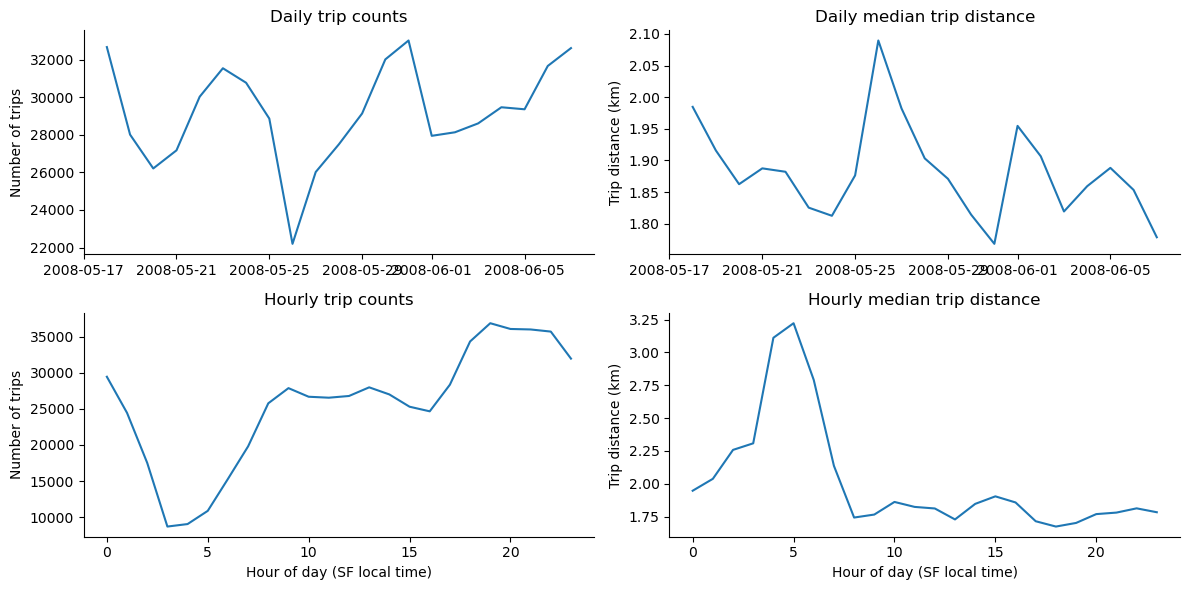

In [5]:
daily = (
    df.groupby("date")["dist_m"]
      .agg(
          count="size",
          median="median"
      )
      .reset_index()
)

hourly = (
    df.groupby("hour")["dist_m"]
      .agg(
          count="size",
          median="median"
      )
      .reset_index()
)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# -------------------
axes[0, 0].plot(daily["date"], daily["count"])
axes[0, 0].set_title("Daily trip counts")
axes[0, 0].set_ylabel("Number of trips")

axes[0, 1].plot(daily["date"], daily["median"] / 1000)
axes[0, 1].set_title("Daily median trip distance")
axes[0, 1].set_ylabel("Trip distance (km)")

# -------------------
axes[1, 0].plot(hourly["hour"], hourly["count"])
axes[1, 0].set_title("Hourly trip counts")
axes[1, 0].set_xlabel("Hour of day (SF local time)")
axes[1, 0].set_ylabel("Number of trips")

axes[1, 1].plot(hourly["hour"], hourly["median"] / 1000)
axes[1, 1].set_title("Hourly median trip distance")
axes[1, 1].set_xlabel("Hour of day (SF local time)")
axes[1, 1].set_ylabel("Trip distance (km)")

for ax in axes.flat:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


## 5) Plot aggregated tract-level trip counts

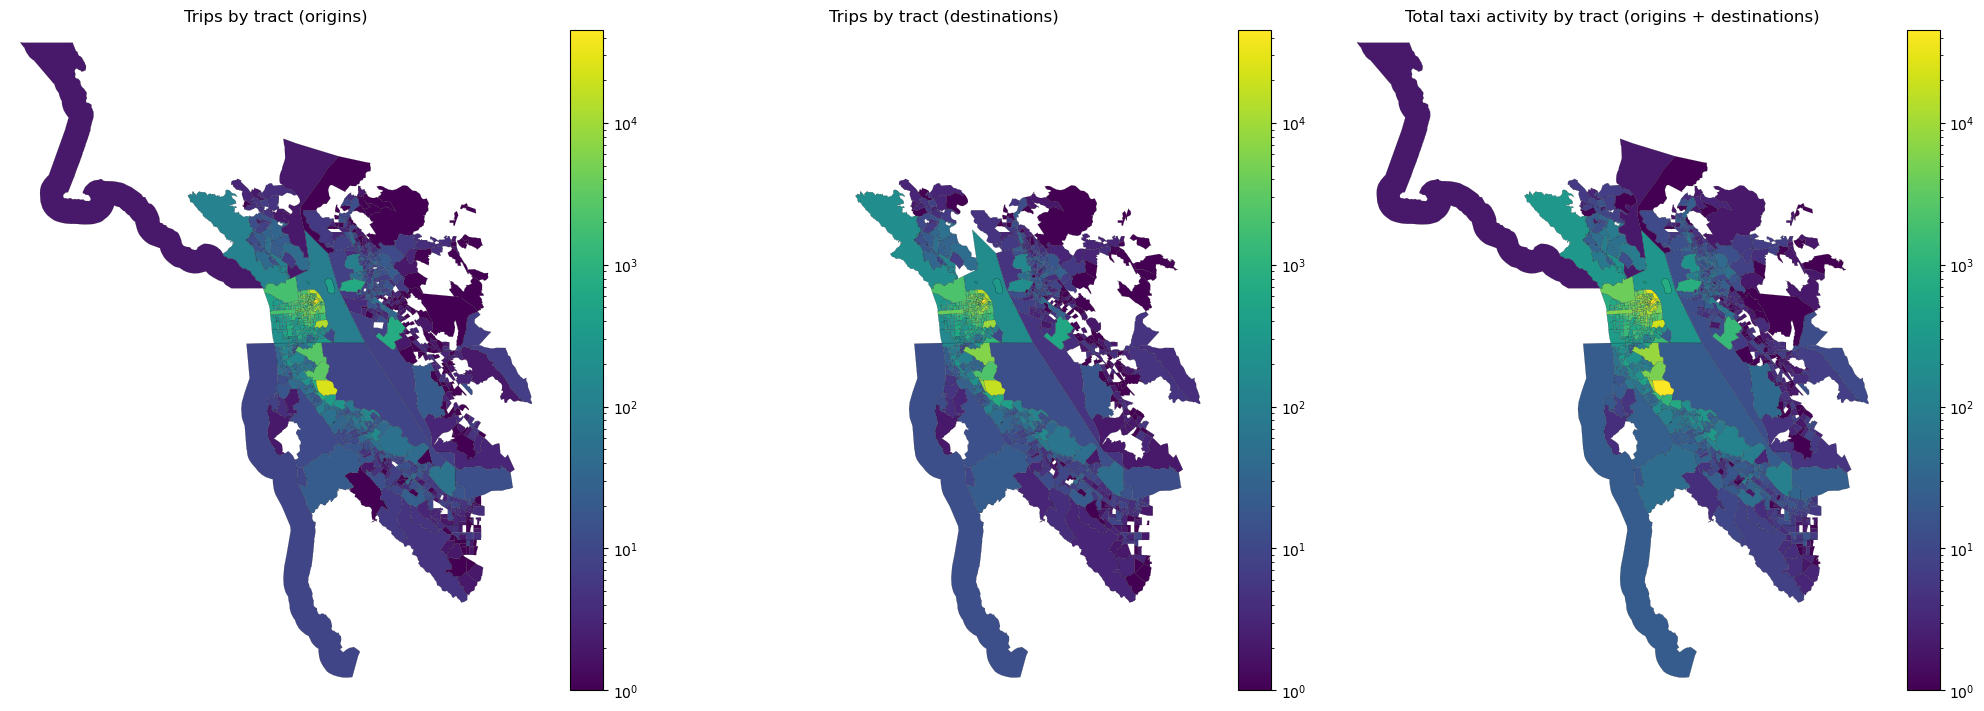

In [6]:
from matplotlib.colors import LogNorm

# counts by tract
o_counts = df.groupby("o_geoid").size().rename("start_count").reset_index()
d_counts = df.groupby("d_geoid").size().rename("end_count").reset_index()

tracts_o = tracts.merge(o_counts, left_on="geoid", right_on="o_geoid", how="left").drop(columns=["o_geoid"])
tracts_d = tracts.merge(d_counts, left_on="geoid", right_on="d_geoid", how="left").drop(columns=["d_geoid"])

tracts_o["start_count"] = tracts_o["start_count"].fillna(0).astype(int)
tracts_d["end_count"]   = tracts_d["end_count"].fillna(0).astype(int)

# total activity map
tracts_t = tracts.copy()
tracts_t = tracts_t.merge(o_counts, left_on="geoid", right_on="o_geoid", how="left")
tracts_t = tracts_t.merge(d_counts, left_on="geoid", right_on="d_geoid", how="left")
tracts_t["start_count"] = tracts_t["start_count"].fillna(0)
tracts_t["end_count"]   = tracts_t["end_count"].fillna(0)
tracts_t["total_count"] = (tracts_t["start_count"] + tracts_t["end_count"]).astype(int)
tracts_t = tracts_t.drop(columns=["o_geoid", "d_geoid"])

# remove empty tracts
tracts_o = tracts_o[tracts_o["start_count"] > 0]
tracts_d = tracts_d[tracts_d["end_count"] > 0]
tracts_t = tracts_t[tracts_t["total_count"] > 0]

# common bounding box
xmin = min(tracts_o.total_bounds[0], tracts_d.total_bounds[0], tracts_t.total_bounds[0])
ymin = min(tracts_o.total_bounds[1], tracts_d.total_bounds[1], tracts_t.total_bounds[1])
xmax = max(tracts_o.total_bounds[2], tracts_d.total_bounds[2], tracts_t.total_bounds[2])
ymax = max(tracts_o.total_bounds[3], tracts_d.total_bounds[3], tracts_t.total_bounds[3])

pad_x = 0.02 * (xmax - xmin)
pad_y = 0.02 * (ymax - ymin)
xmin -= pad_x; xmax += pad_x
ymin -= pad_y; ymax += pad_y

# shared log scale
vmin = min(
    tracts_o["start_count"].min(),
    tracts_d["end_count"].min()
)
vmax = max(
    tracts_o["start_count"].max(),
    tracts_d["end_count"].max()
)

norm = LogNorm(vmin=vmin, vmax=vmax)

# plot: 3 maps
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)

tracts_o.plot(
    column="start_count",
    ax=axes[0],
    cmap="viridis",
    norm=norm,
    linewidth=0.1,
    edgecolor="black",
    legend=True
)
axes[0].set_title("Trips by tract (origins)")
axes[0].set_xlim(xmin, xmax)
axes[0].set_ylim(ymin, ymax)
axes[0].axis("off")

tracts_d.plot(
    column="end_count",
    ax=axes[1],
    cmap="viridis",
    norm=norm,
    linewidth=0.1,
    edgecolor="black",
    legend=True
)
axes[1].set_title("Trips by tract (destinations)")
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylim(ymin, ymax)
axes[1].axis("off")

tracts_t.plot(
    column="total_count",
    ax=axes[2],
    cmap="viridis",
    norm=norm,
    linewidth=0.1,
    edgecolor="black",
    legend=True
)
axes[2].set_title("Total taxi activity by tract (origins + destinations)")
axes[2].set_xlim(xmin, xmax)
axes[2].set_ylim(ymin, ymax)
axes[2].axis("off")

plt.show()


## 6) Build tract-level OD networks and compute metrics

Metrics implemented:
- degree/strength distributions (in/out)
- edge weight Gini

Computed per time bin (hourly or daily) and can be stratified later.

In [7]:
def gini(x):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan
    if np.all(x == 0):
        return 0.0
    x = np.sort(x)
    n = x.size
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n


def build_edges(trips, tcol, ocol="o_geoid", dcol="d_geoid"):
    edges = (trips.groupby([tcol, ocol, dcol], as_index=False)
                  .agg(w=("trajectory", "size"),
                       dist_mean_m=("dist_m", "mean")))
    return edges

def network_metrics(edges_bin):
    G = nx.DiGraph()
    for _, r in edges_bin.iterrows():
        G.add_edge(r["o_geoid"], r["d_geoid"], weight=float(r["w"]), dist_mean_m=float(r["dist_mean_m"]))

    w = np.array([d["weight"] for _, _, d in G.edges(data=True)], dtype=float)

    out_deg = np.array([d for _, d in G.out_degree()], dtype=float)
    in_deg  = np.array([d for _, d in G.in_degree()], dtype=float)
    out_str = np.array([s for _, s in G.out_degree(weight="weight")], dtype=float)
    in_str  = np.array([s for _, s in G.in_degree(weight="weight")], dtype=float)

    dists = np.array([d["dist_mean_m"] for _, _, d in G.edges(data=True)], dtype=float)
    dist_mean = float(np.nanmean(dists)) if dists.size else np.nan
    dist_p50  = float(np.nanpercentile(dists, 50)) if dists.size else np.nan

    return {
        "n_nodes": G.number_of_nodes(),
        "n_edges": G.number_of_edges(),
        "edge_weight_gini": gini(w),
        "out_degree_p50": float(np.nanpercentile(out_deg, 50)) if out_deg.size else np.nan,
        "in_degree_p50": float(np.nanpercentile(in_deg, 50)) if in_deg.size else np.nan,
        "out_strength_p50": float(np.nanpercentile(out_str, 50)) if out_str.size else np.nan,
        "in_strength_p50": float(np.nanpercentile(in_str, 50)) if in_str.size else np.nan,
        "dist_mean_m": dist_mean,
        "dist_p50_m": dist_p50
    }

def metrics_over_time(edges, tcol):
    out = []
    for t, g in edges.groupby(tcol):
        m = network_metrics(g)
        m[tcol] = t
        out.append(m)
    return pd.DataFrame(out).sort_values(tcol)

# different time bins
df["tbin_hour"] = df["timestamp"].dt.floor("H")
df["tbin_day"] = df["timestamp"].dt.floor("D")

edges_h = build_edges(df, "tbin_hour")
edges_d = build_edges(df, "tbin_day")

m_h = metrics_over_time(edges_h, "tbin_hour")
m_d = metrics_over_time(edges_d, "tbin_day")


/var/folders/z1/bkb7kng57wn1qdtl9dy0t9280000gn/T/ipykernel_87325/302799196.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["tbin_hour"] = df["timestamp"].dt.floor("H")


### Plots of a few network-level metrics over time

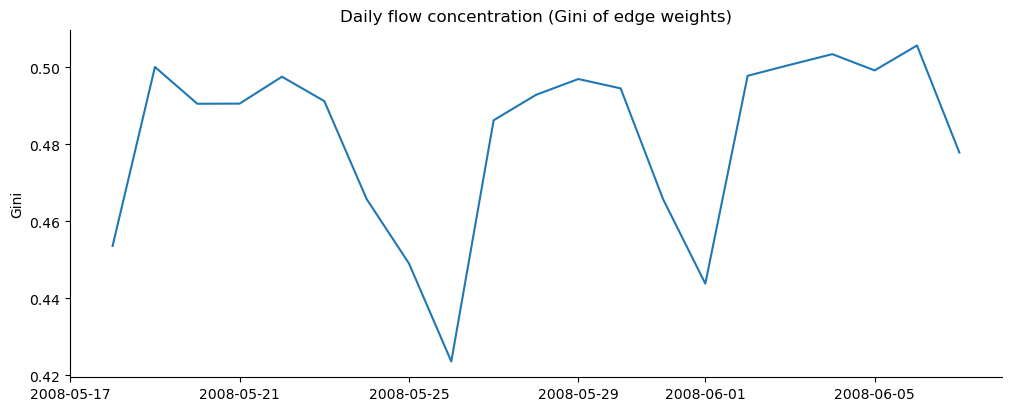

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), constrained_layout=True)
ax.plot(m_d["tbin_day"], m_d["edge_weight_gini"])
ax.set_title("Daily flow concentration (Gini of edge weights)")
ax.set_ylabel("Gini")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

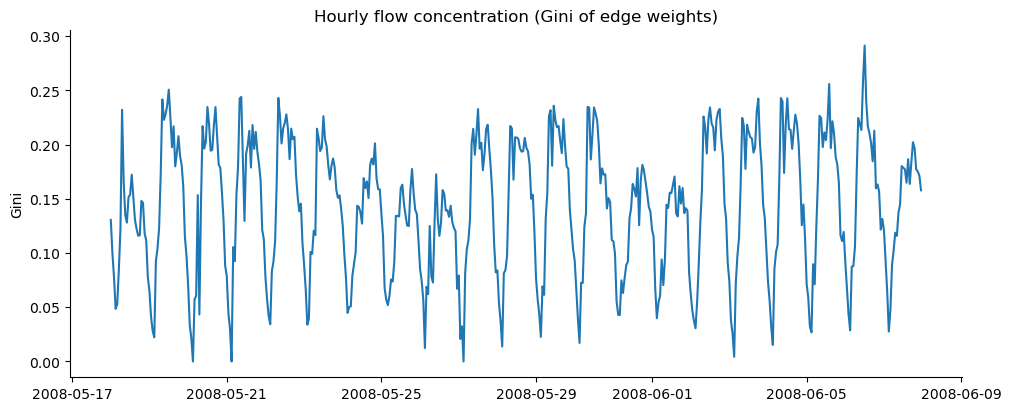

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), constrained_layout=True)
ax.plot(m_h["tbin_hour"], m_h["edge_weight_gini"])
ax.set_title("Hourly flow concentration (Gini of edge weights)")
ax.set_ylabel("Gini")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

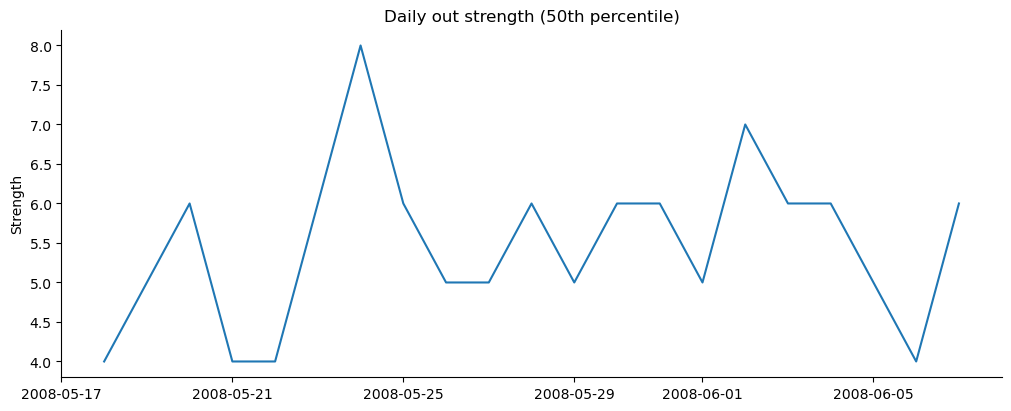

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), constrained_layout=True)
ax.plot(m_d["tbin_day"], m_d["out_strength_p50"])
ax.set_title("Daily out strength (50th percentile)")
ax.set_ylabel("Strength")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

## 6) Demographic proxies,  urban/rural stratification, socioeconomic segregation -> for further development

This section allow to attach tract-level attributes (e.g. income, population density, urban/rural flags).


In [ ]:
ATTR_INCOME = "med_income"  
ATTR_POPDENS = "pop_density" 
ATTR_URBAN = "urban_rural"

node_attrs = tracts[[TRACT_ID_COL]].copy().rename(columns={TRACT_ID_COL: "geoid"}).set_index("geoid")

for col in [ATTR_INCOME, ATTR_POPDENS, ATTR_URBAN]:
    if col in tracts.columns:
        node_attrs[col] = tracts.set_index(TRACT_ID_COL)[col]

# income bins (five quintiles) for segregation/assortativity (assuming income is available)
if ATTR_INCOME in node_attrs.columns:
    node_attrs["income_bin"] = pd.qcut(node_attrs[ATTR_INCOME], q=5, labels=False, duplicates="drop").astype("Int64")

# urban/rural if only population density is available
if ATTR_URBAN not in node_attrs.columns and ATTR_POPDENS in node_attrs.columns:
    node_attrs["urban_rural"] = np.where(node_attrs[ATTR_POPDENS] >= node_attrs[ATTR_POPDENS].median(), "urban", "rural")
